# Framework for Assessing Changes to Sea Level (FACTS)

*Much of the text in this notebook is adapted from
[R. E. Kopp et al. (2023), Geoscientific Model Development, 16: 7461](https://doi.org/10.5194/gmd-16-7461-2023)
and the [FACTS documentation](https://fact-sealevel.readthedocs.io/). Please see those resources for more information*

FACTS is an open-source modular, scalable, and extensive framework for global mean, regional, and extreme sea level projection that is designed to support the characterization of ambiguity in sea-level projections. It is designed so users can easily explore deep uncertainty by investigating the implications on global-mean sea level (GMSL), relative sea level (RSL), and extreme sea level (ESL) of different choices for different processes. Its modularity allows components to be represented by either simple or complex model. Because it is built upon the RADICAL Cybertools computing stack, different modules can be dispatched for execution on resources appropriate to their computational complexity.

FACTS consists of the FACTS Manager (FACTS.py), which oversees the execution of FACTS experiments, and an extendable suite of modules, which provide the scientific and analytical core that allows FACTS to simulate the different process contributing to GMSL, RSL, and ESL change. Modules represent independent processes (e.g., sterodynamic sea-level change or VLM) and can be run in parallel on high-performance computing (HPC) resources. Modules can also be run in sequence when their outputs depend upon inputs from other modules (e.g., the modules that compute total RSL change and ESL distribution shifts).

A FACTS experiment consists of a series of experiment steps. Typical experiment steps include (1) a climate experiment step, which translates an inputted emissions scenario into projections of global mean surface air temperature (GSAT) and ocean heat content change; (2) a sea-level component experiment step, which simulates the different physical processes driving sea-level change; (3) an integration experiment step, which adds up the different components into projections of total GMSL and RSL change; and (4) an ESL experiment step, which uses tide gauge data and RSL projections to project the change in extreme sea-level occurrences over time.

Each experiment step runs one or more modules in parallel. Exchange of information between modules happens between experiment steps. This exchange is mediated by the file system, so experiment steps can be bypassed simply by providing appropriate input files (e.g., stored GSAT and ocean heat content trajectories) to the subsequent experiment step. Though the existing usage of FACTS contains only one sea-level component experiment step, and therefore treats the output of each module as independent conditional upon their common dependence on the climate simulated in the climate experiment step, the FACTS Manager allows experiment steps to be subdivided and could thus support between-module coupling.

The core concept of workflow provides FACTS with the flexibility required to explore structural uncertainty. A workflow consists of a set of sea-level component modules that are added together in the integration experiment step to produce a probabilistic estimate of their combined contribution to sea-level change. Workflows can be overlapping: for example, two workflows might use the same module for simulating sterodynamic sea-level change but use different modules for simulating ice sheet change. Modules run in the sea-level component experiment step are tagged as belonging to one or more workflows; those workflows are then aggregated at the integration experiment step. This structure allows a single sea-level components experiment step to include multiple modules representing alternative methods to simulate the same sea-level component and avoids redundant execution of modules employed in multiple workflows.

In practice, for a specific set of climate inputs (e.g., emissions scenario-forced GSAT projections), a single workflow produces a single (climate input-conditional) probabilistic projection of sea-level change. Multiple workflows can be compared to examine the structural uncertainty of GMSL, RSL, and ESL change to the choice of component methods (i.e., the ambiguity of projections) and combined (for example, in a p-box) to produce summary outputs that capture ambiguity. (See [R. E. Kopp et al., (2023), Nature Climate Change 13: 648](https://doi.org/10.1038/s41558-023-01691-8) for more discussion of this topic.)

In [1]:
import os 
import sys
import numpy as np
import dask
import xarray as xr
import matplotlib.pyplot as plt

## Configure FACTS run

FACTS experiment configurations are specified by an experiment directory containing a `config.yml` file. This section of the notebook creates experiment directories and associated `config.yml` files for a series of experiments that are identical with the exception of the scenario specified.

### Configure directories and scenarios

In [ ]:
# Configure directories and experiment

factsdir = '/opt/facts' # FACTS root directory
experiment_root_dir = os.path.join(factsdir, 'experiments') # directory with experiment configs
out_dir = os.path.join(factsdir, 'output') # directory to put output files in

exp_prefix = 'jupyter01' # desired experiment name prefix
scenarios = [ 'ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp585'] #scenarios to run

### Specify global experiment options

The **global-options** section of `config.yml` specifies options that should, by default, apply to every module (but can be overwritten by module-level configuration). Common global options include:

* **nsamps**: number of samples to run
* **scenario**: climate scenario to use
* **pyear_start**: year in which to start projection
* **pyear_step**: step size between projection years
* **pyear_end**: year in which to end projections
* **baseyear**: zero point for sea level projections
* **pipeline_file**: default pipeline file name (optional; defaults to 'pipeline.yml'). See *pipeline_file* under experiment step configuration.


In [ ]:
# specify global experiment options
experiment_config_global = """ 
global-options:
    nsamps: 200
    pyear_start: 2020
    pyear_end: 2150
    pyear_step: 10
    baseyear: 2005
    pipeline_file: 'pipeline.global.yml'
    scenario: """

### Specify Experiment Steps

All other top-level entries in `config.yml` specify experiment steps. The label of these are arbitrary, though common labels are *climate_step*, *sealevel_step*, *totaling_step* and *esl_step*.

The second-level entries under the experiment steps specify the modules to be run. Module labels are arbitrary, and are used together with the experiment name to label output files.

Third-level entries used under the module label include:

* **module_set** (required): the name of the module set (first level hierarchy in the modules/ directory)

* **module** (required): the name of the module (second level hierarchy in the climate directory)

* **options**: Entries under this header are passed as options to the modules if they match options defined in the module pipeline.yml. These overwrite global options.

* **include_in_workflow**: A list of all workflows the module output should be included in at the totaling steps.

* **loop_over_workflows**: If defined, replicate the module for all workflows defined to date.

* **loop_over_scales**: If defined, replicate the module for both global and local scale (e.g., for a totaling module).

* **stages**: Specifies stages from the pipeline file file to be run. Defaults to 'preprocess', 'fit', 'project', 'postprocess'.

* **generates_climate_output**: Module generates climate output data. Globally set ```climate_output_data``` based on the module's pipeline configuration.

See the [FACTS documentation](https://fact-sealevel.readthedocs.io/en/latest/) for additional options.


In [ ]:
# specify Experiment Steps
experiment_config_steps = """

climate_step:
    temperature:
        module_set: "fair"
        module: "temperature"
        generates_climate_output: true

sealevel_step:
    GrIS1f:
        module_set: "FittedISMIP"
        module: "GrIS"
        include_in_workflow:
            - "wf1f"
            - "wf2f"
            - "wf3f"

    deconto21:
        module_set: "deconto21"
        module: "AIS"
        include_in_workflow:
            - "wf3f"

    bamber19:
        module_set: "bamber19"
        module: "icesheets"
        include_in_workflow:
            - "wf4"

    larmip:
        module_set: "larmip"
        module: "AIS"
        include_in_workflow:
            - "wf2f"

    ar5glaciers:
        module_set: "ipccar5"
        module: "glaciers"
        options:
            gmip: 2
        include_in_workflow:
            - "wf1f"
            - "wf2f"
            - "wf3f"
            - "wf4"

    ar5AIS:
        module_set: "ipccar5"
        module: "icesheets"
        pipeline_file: "pipeline.AIS.global.yml"
        include_in_workflow:
            - "wf1f"

    ocean:
        module_set: "tlm"
        module: "sterodynamics"
        include_in_workflow:
            - "wf1f"
            - "wf2f"
            - "wf3f"
            - "wf4"

    lws:
        module_set: "ssp"
        module: "landwaterstorage"
        options:
            scenario: "ssp2"
            dcrate_lo: -0.4
        include_in_workflow:
            - "wf1f"
            - "wf2f"
            - "wf3f"
            - "wf4"


totaling_step:
    total:
        module_set: "facts"
        module: "total"
        loop_over_workflows: true
        loop_over_scales: true
        stages:
            - workflow

"""

### Write the experiment `config.yml` files 

This subsection writes the configuration files described in the previous subsections to files.

In [ ]:
exp_names = [ exp_prefix + '.' + scen for scen in scenarios]
exp_configs = [ experiment_config_global + scen + experiment_config_steps for scen in scenarios]
exp_dirs = [os.path.join(experiment_root_dir, exp_name) for exp_name in exp_names]

In [3]:
os.chdir(factsdir)
import runFACTS

for i in np.arange(len(scenarios)):
    
    try:
        os.makedirs(exp_dirs[i])
    except:
        None

    f = open(os.path.join(exp_dirs[i],'config.yml'),'w')
    f.write(exp_configs[i])
    f.close()


## Run FACTS

Run the newly created FACTS experiments.

In [4]:
resource_dir=os.path.join(factsdir,'resources') # specify the location of the resources directory

lazy_scenario = [dask.delayed(runFACTS.run_experiment(exp_dir=exp_dir,
                                                      resourcedir=resource_dir, 
                                                      outdir=out_dir)) for exp_dir in exp_dirs] 
run_scenarios = dask.compute(*lazy_scenario)

EnTK session: re.session.b02e4dfa-d135-11ee-b1ee-0242ac110002
Creating AppManager
Setting up ZMQ queues                                                         ok


Framework for Assessing Changes To Sea-level (FACTS)

Running experiment in directory: /opt/facts/experiments/jupyter01.ssp119
Resource directory: /opt/facts/resources
Output directory: /opt/facts/output
-------------


AppManager initialized                                                        ok
Validating and assigning resource manager                                     ok
Setting up ZMQ queues                                                        n/a


****** STEP: climate_step ******


All components created
Update: jupyter01.ssp119.temperature.fair.temperature state: SCHEDULING
Update: jupyter01.ssp119.temperature.fair.temperature.preprocess state: SCHEDULING
Update: jupyter01.ssp119.temperature.fair.temperature.preprocess.task1 state: SCHEDULING
Update: jupyter01.ssp119.temperature.fair.temperature.preprocess.task1 state: SCHEDULED
Update: jupyter01.ssp119.temperature.fair.temperature.preprocess state: SCHEDULED
Update: jupyter01.ssp119.temperature.fair.temperature.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp119.temperature.fair.temperature.preprocess.task1 state: DONE
Update: jupyter01.ssp119.temperature.fair.temperature.preprocess state: DONE
Update: jupyter01.ssp119.temperature.fair.temperature.fit state: SCHEDULING
Update: jupyter01.ssp119.temperature.fair.temperature.fit.task1 state: SCHEDULING
Update: jupyter01.ssp119.temperature.fair.temperature.fit.task1 state: SCHEDULED
Update: jupyter01.ssp119.temperature.fair.temperature.fit state: SCHEDULED


****** STEP: sealevel_step ******


jupyter01.ssp119.ar5glaciers.ipccar5.glaciers.preprocess.task1 state: SCHEDULED
Update: Update: jupyter01.ssp119.ar5AIS.ipccar5.icesheets.preprocess.task1 state: SCHEDULED
jupyter01.ssp119.GrIS1f.FittedISMIP.GrIS.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp119.ocean.tlm.sterodynamics.preprocess.task1 state: SCHEDULED
Update: jupyter01.ssp119.lws.ssp.landwaterstorage.preprocess.task1 state: SCHEDULED
Update: jupyter01.ssp119.GrIS1f.FittedISMIP.GrIS.preprocess state: SCHEDULED
Update: jupyter01.ssp119.deconto21.deconto21.AIS.preprocess state: SCHEDULED
Update: jupyter01.ssp119.bamber19.bamber19.icesheets.preprocess state: SCHEDULED
Update: jupyter01.ssp119.deconto21.deconto21.AIS.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp119.larmip.larmip.AIS.preprocess state: SCHEDULED
Update: jupyter01.ssp119.ar5glaciers.ipccar5.glaciers.preprocess state: SCHEDULED
Update: jupyter01.ssp119.ar5AIS.ipccar5.icesheets.preprocess state: SCHEDULED
Update: jupyter01.ssp119.ocean.tlm.

****** STEP: totaling_step ******


Update: jupyter01.ssp119.total.facts.total.wf4.global.workflow.task1 state: SUBMITTING
Update: jupyter01.ssp119.total.facts.total.wf1f.global.workflow.task1 state: DONE
Update: jupyter01.ssp119.total.facts.total.wf1f.global.workflow state: DONE
Update: jupyter01.ssp119.total.facts.total.wf1f.global state: DONE
Update: jupyter01.ssp119.total.facts.total.wf2f.global.workflow.task1 state: DONE
Update: jupyter01.ssp119.total.facts.total.wf2f.global.workflow state: DONE
Update: jupyter01.ssp119.total.facts.total.wf2f.global state: DONE
Update: jupyter01.ssp119.total.facts.total.wf3f.global.workflow.task1 state: DONE
Update: jupyter01.ssp119.total.facts.total.wf3f.global.workflow state: DONE
Update: jupyter01.ssp119.total.facts.total.wf3f.global state: DONE
Update: jupyter01.ssp119.total.facts.total.wf4.global.workflow.task1 state: DONE
Update: jupyter01.ssp119.total.facts.total.wf4.global.workflow state: DONE
Update: jupyter01.ssp119.total.facts.total.wf4.global state: DONE
All components t

Framework for Assessing Changes To Sea-level (FACTS)

Running experiment in directory: /opt/facts/experiments/jupyter01.ssp126
Resource directory: /opt/facts/resources
Output directory: /opt/facts/output
-------------


AppManager initialized                                                        ok
Validating and assigning resource manager                                     ok
Setting up ZMQ queues                                                        n/a


****** STEP: climate_step ******


All components created
Update: jupyter01.ssp126.temperature.fair.temperature state: SCHEDULING
Update: jupyter01.ssp126.temperature.fair.temperature.preprocess state: SCHEDULING
Update: jupyter01.ssp126.temperature.fair.temperature.preprocess.task1 state: SCHEDULING
Update: jupyter01.ssp126.temperature.fair.temperature.preprocess.task1 state: SCHEDULED
Update: jupyter01.ssp126.temperature.fair.temperature.preprocess state: SCHEDULED
Update: jupyter01.ssp126.temperature.fair.temperature.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp126.temperature.fair.temperature.preprocess.task1 state: DONE
Update: jupyter01.ssp126.temperature.fair.temperature.preprocess state: DONE
Update: jupyter01.ssp126.temperature.fair.temperature.fit state: SCHEDULING
Update: jupyter01.ssp126.temperature.fair.temperature.fit.task1 state: SCHEDULING
Update: jupyter01.ssp126.temperature.fair.temperature.fit.task1 state: SCHEDULED
Update: jupyter01.ssp126.temperature.fair.temperature.fit state: SCHEDULED


****** STEP: sealevel_step ******


Update: jupyter01.ssp126.bamber19.bamber19.icesheets.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp126.larmip.larmip.AIS.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp126.ar5glaciers.ipccar5.glaciers.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp126.ar5AIS.ipccar5.icesheets.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp126.ocean.tlm.sterodynamics.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp126.lws.ssp.landwaterstorage.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp126.GrIS1f.FittedISMIP.GrIS.preprocess.task1 state: EXECUTED
Update: jupyter01.ssp126.GrIS1f.FittedISMIP.GrIS.preprocess.task1 state: DONE
Update: jupyter01.ssp126.GrIS1f.FittedISMIP.GrIS.preprocess state: DONE
Update: jupyter01.ssp126.GrIS1f.FittedISMIP.GrIS.fit state: SCHEDULING
Update: jupyter01.ssp126.GrIS1f.FittedISMIP.GrIS.fit.task1 state: SCHEDULING
Update: jupyter01.ssp126.GrIS1f.FittedISMIP.GrIS.fit.task1 state: SCHEDULED
Update: jupyter01.ssp126.GrIS1f.Fit

****** STEP: totaling_step ******


jupyter01.ssp126.total.facts.total.wf1f.global.workflow state: SCHEDULED
Update: jupyter01.ssp126.total.facts.total.wf2f.global.workflow state: SCHEDULED
Update: jupyter01.ssp126.total.facts.total.wf3f.global.workflow state: SCHEDULED
Update: jupyter01.ssp126.total.facts.total.wf1f.global.workflow.task1 state: SUBMITTING
Update: jupyter01.ssp126.total.facts.total.wf4.global.workflow state: SCHEDULED
Update: jupyter01.ssp126.total.facts.total.wf2f.global.workflow.task1 state: SUBMITTING
Update: jupyter01.ssp126.total.facts.total.wf3f.global.workflow.task1 state: SUBMITTING
Update: jupyter01.ssp126.total.facts.total.wf4.global.workflow.task1 state: SUBMITTING
Update: jupyter01.ssp126.total.facts.total.wf1f.global.workflow.task1 state: DONE
Update: jupyter01.ssp126.total.facts.total.wf1f.global.workflow state: DONE
Update: jupyter01.ssp126.total.facts.total.wf1f.global state: DONE
Update: jupyter01.ssp126.total.facts.total.wf2f.global.workflow.task1 state: DONE
Update: jupyter01.ssp126.to

Framework for Assessing Changes To Sea-level (FACTS)

Running experiment in directory: /opt/facts/experiments/jupyter01.ssp245
Resource directory: /opt/facts/resources
Output directory: /opt/facts/output
-------------


AppManager initialized                                                        ok
Validating and assigning resource manager                                     ok
Setting up ZMQ queues                                                        n/a


****** STEP: climate_step ******


All components created
Update: jupyter01.ssp245.temperature.fair.temperature state: SCHEDULING
Update: jupyter01.ssp245.temperature.fair.temperature.preprocess state: SCHEDULING
Update: jupyter01.ssp245.temperature.fair.temperature.preprocess.task1 state: SCHEDULING
Update: jupyter01.ssp245.temperature.fair.temperature.preprocess.task1 state: SCHEDULED
Update: jupyter01.ssp245.temperature.fair.temperature.preprocess state: SCHEDULED
Update: jupyter01.ssp245.temperature.fair.temperature.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp245.temperature.fair.temperature.preprocess.task1 state: DONE
Update: jupyter01.ssp245.temperature.fair.temperature.preprocess state: DONE
Update: jupyter01.ssp245.temperature.fair.temperature.fit state: SCHEDULING
Update: jupyter01.ssp245.temperature.fair.temperature.fit.task1 state: SCHEDULING
Update: jupyter01.ssp245.temperature.fair.temperature.fit.task1 state: SCHEDULED
Update: jupyter01.ssp245.temperature.fair.temperature.fit state: SCHEDULED


****** STEP: sealevel_step ******


jupyter01.ssp245.deconto21.deconto21.AIS.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp245.bamber19.bamber19.icesheets.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp245.larmip.larmip.AIS.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp245.ar5glaciers.ipccar5.glaciers.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp245.ar5AIS.ipccar5.icesheets.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp245.ocean.tlm.sterodynamics.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp245.lws.ssp.landwaterstorage.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp245.GrIS1f.FittedISMIP.GrIS.preprocess.task1 state: EXECUTED
Update: jupyter01.ssp245.GrIS1f.FittedISMIP.GrIS.preprocess.task1 state: DONE
Update: jupyter01.ssp245.GrIS1f.FittedISMIP.GrIS.preprocess state: DONE
Update: jupyter01.ssp245.GrIS1f.FittedISMIP.GrIS.fit state: SCHEDULING
Update: jupyter01.ssp245.GrIS1f.FittedISMIP.GrIS.fit.task1 state: SCHEDULING
Update: jupyter01.ssp245.GrIS1f.Fit

****** STEP: totaling_step ******


Update: jupyter01.ssp245.total.facts.total.wf2f.global.workflow.task1 state: SUBMITTING
Update: jupyter01.ssp245.total.facts.total.wf3f.global.workflow.task1 state: SUBMITTING
Update: jupyter01.ssp245.total.facts.total.wf4.global.workflow.task1 state: SUBMITTING
Update: jupyter01.ssp245.total.facts.total.wf1f.global.workflow.task1 state: DONE
Update: jupyter01.ssp245.total.facts.total.wf1f.global.workflow state: DONE
Update: jupyter01.ssp245.total.facts.total.wf1f.global state: DONE
Update: jupyter01.ssp245.total.facts.total.wf2f.global.workflow.task1 state: EXECUTED
Update: jupyter01.ssp245.total.facts.total.wf2f.global.workflow.task1 state: DONE
Update: jupyter01.ssp245.total.facts.total.wf2f.global.workflow state: DONE
Update: jupyter01.ssp245.total.facts.total.wf2f.global state: DONE
Update: jupyter01.ssp245.total.facts.total.wf3f.global.workflow.task1 state: EXECUTED
Update: jupyter01.ssp245.total.facts.total.wf3f.global.workflow.task1 state: DONE
Update: jupyter01.ssp245.total.fa

Framework for Assessing Changes To Sea-level (FACTS)

Running experiment in directory: /opt/facts/experiments/jupyter01.ssp370
Resource directory: /opt/facts/resources
Output directory: /opt/facts/output
-------------


AppManager initialized                                                        ok
Validating and assigning resource manager                                     ok
Setting up ZMQ queues                                                        n/a


****** STEP: climate_step ******


All components created
Update: jupyter01.ssp370.temperature.fair.temperature state: SCHEDULING
Update: jupyter01.ssp370.temperature.fair.temperature.preprocess state: SCHEDULING
Update: jupyter01.ssp370.temperature.fair.temperature.preprocess.task1 state: SCHEDULING
Update: jupyter01.ssp370.temperature.fair.temperature.preprocess.task1 state: SCHEDULED
Update: jupyter01.ssp370.temperature.fair.temperature.preprocess state: SCHEDULED
Update: jupyter01.ssp370.temperature.fair.temperature.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp370.temperature.fair.temperature.preprocess.task1 state: DONE
Update: jupyter01.ssp370.temperature.fair.temperature.preprocess state: DONE
Update: jupyter01.ssp370.temperature.fair.temperature.fit state: SCHEDULING
Update: jupyter01.ssp370.temperature.fair.temperature.fit.task1 state: SCHEDULING
Update: jupyter01.ssp370.temperature.fair.temperature.fit.task1 state: SCHEDULED
Update: jupyter01.ssp370.temperature.fair.temperature.fit state: SCHEDULED


****** STEP: sealevel_step ******


jupyter01.ssp370.deconto21.deconto21.AIS.preprocess.task1 state: SCHEDULED
Update: jupyter01.ssp370.bamber19.bamber19.icesheets.preprocess.task1 state: SCHEDULED
Update: jupyter01.ssp370.larmip.larmip.AIS.preprocess.task1 state: SCHEDULED
Update: jupyter01.ssp370.ar5glaciers.ipccar5.glaciers.preprocess.task1 state: SCHEDULED
Update: jupyter01.ssp370.ar5AIS.ipccar5.icesheets.preprocess.task1 state: SCHEDULED
Update: jupyter01.ssp370.ocean.tlm.sterodynamics.preprocess.task1 state: SCHEDULED
Update: Update: jupyter01.ssp370.GrIS1f.FittedISMIP.GrIS.preprocess.task1 state: SUBMITTING
jupyter01.ssp370.lws.ssp.landwaterstorage.preprocess.task1 state: SCHEDULED
Update: jupyter01.ssp370.GrIS1f.FittedISMIP.GrIS.preprocess state: SCHEDULED
Update: jupyter01.ssp370.deconto21.deconto21.AIS.preprocess state: SCHEDULED
Update: jupyter01.ssp370.bamber19.bamber19.icesheets.preprocess state: SCHEDULED
Update: jupyter01.ssp370.larmip.larmip.AIS.preprocess state: SCHEDULED
Update: jupyter01.ssp370.ar5glac

****** STEP: totaling_step ******


jupyter01.ssp370.total.facts.total.wf4.global.workflow.task1 state: SCHEDULED
Update: jupyter01.ssp370.total.facts.total.wf1f.global.workflow state: SCHEDULED
Update: jupyter01.ssp370.total.facts.total.wf2f.global.workflow state: SCHEDULED
Update: Update: jupyter01.ssp370.total.facts.total.wf3f.global.workflow state: SCHEDULED
jupyter01.ssp370.total.facts.total.wf1f.global.workflow.task1 state: SUBMITTING
Update: jupyter01.ssp370.total.facts.total.wf4.global.workflow state: SCHEDULED
Update: jupyter01.ssp370.total.facts.total.wf2f.global.workflow.task1 state: SUBMITTING
Update: jupyter01.ssp370.total.facts.total.wf3f.global.workflow.task1 state: SUBMITTING
Update: jupyter01.ssp370.total.facts.total.wf4.global.workflow.task1 state: SUBMITTING
Update: jupyter01.ssp370.total.facts.total.wf1f.global.workflow.task1 state: DONE
Update: jupyter01.ssp370.total.facts.total.wf1f.global.workflow state: DONE
Update: jupyter01.ssp370.total.facts.total.wf1f.global state: DONE
Update: jupyter01.ssp37

Framework for Assessing Changes To Sea-level (FACTS)

Running experiment in directory: /opt/facts/experiments/jupyter01.ssp585
Resource directory: /opt/facts/resources
Output directory: /opt/facts/output
-------------


AppManager initialized                                                        ok
Validating and assigning resource manager                                     ok
Setting up ZMQ queues                                                        n/a


****** STEP: climate_step ******


All components created
Update: jupyter01.ssp585.temperature.fair.temperature state: SCHEDULING
Update: jupyter01.ssp585.temperature.fair.temperature.preprocess state: SCHEDULING
Update: jupyter01.ssp585.temperature.fair.temperature.preprocess.task1 state: SCHEDULING
Update: jupyter01.ssp585.temperature.fair.temperature.preprocess.task1 state: SCHEDULED
Update: jupyter01.ssp585.temperature.fair.temperature.preprocess state: SCHEDULED
Update: jupyter01.ssp585.temperature.fair.temperature.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp585.temperature.fair.temperature.preprocess.task1 state: EXECUTED
Update: jupyter01.ssp585.temperature.fair.temperature.preprocess.task1 state: DONE
Update: jupyter01.ssp585.temperature.fair.temperature.preprocess state: DONE
Update: jupyter01.ssp585.temperature.fair.temperature.fit state: SCHEDULING
Update: jupyter01.ssp585.temperature.fair.temperature.fit.task1 state: SCHEDULING
Update: jupyter01.ssp585.temperature.fair.temperature.fit.task1 state

****** STEP: sealevel_step ******


Update: jupyter01.ssp585.deconto21.deconto21.AIS.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp585.bamber19.bamber19.icesheets.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp585.larmip.larmip.AIS.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp585.ar5glaciers.ipccar5.glaciers.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp585.ar5AIS.ipccar5.icesheets.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp585.ocean.tlm.sterodynamics.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp585.lws.ssp.landwaterstorage.preprocess.task1 state: SUBMITTING
Update: jupyter01.ssp585.GrIS1f.FittedISMIP.GrIS.preprocess.task1 state: DONE
Update: jupyter01.ssp585.GrIS1f.FittedISMIP.GrIS.preprocess state: DONE
Update: jupyter01.ssp585.GrIS1f.FittedISMIP.GrIS.fit state: SCHEDULING
Update: jupyter01.ssp585.GrIS1f.FittedISMIP.GrIS.fit.task1 state: SCHEDULING
Update: jupyter01.ssp585.GrIS1f.FittedISMIP.GrIS.fit.task1 state: SCHEDULED
Update: jupyter01.ssp585.GrIS1f.F

****** STEP: totaling_step ******


jupyter01.ssp585.total.facts.total.wf2f.global.workflow.task1 state: SUBMITTING
Update: jupyter01.ssp585.total.facts.total.wf3f.global.workflow.task1 state: SUBMITTING
Update: jupyter01.ssp585.total.facts.total.wf4.global.workflow.task1 state: SUBMITTING
Update: jupyter01.ssp585.total.facts.total.wf1f.global.workflow.task1 state: DONE
Update: jupyter01.ssp585.total.facts.total.wf1f.global.workflow state: DONE
Update: jupyter01.ssp585.total.facts.total.wf1f.global state: DONE
Update: jupyter01.ssp585.total.facts.total.wf2f.global.workflow.task1 state: DONE
Update: jupyter01.ssp585.total.facts.total.wf2f.global.workflow state: DONE
Update: jupyter01.ssp585.total.facts.total.wf2f.global state: DONE
Update: jupyter01.ssp585.total.facts.total.wf3f.global.workflow.task1 state: DONE
Update: jupyter01.ssp585.total.facts.total.wf3f.global.workflow state: DONE
Update: jupyter01.ssp585.total.facts.total.wf3f.global state: DONE
Update: jupyter01.ssp585.total.facts.total.wf4.global.workflow.task1 s

## Visualize output

This section does some simple inspection of the FACTS output just produced.

In [5]:
# List output files

os.listdir(out_dir)

['jupyter01.ssp119.larmip.larmip.AIS_WAIS_globalsl.nc',
 'jupyter01.ssp126.total.workflow.wf3f.global.nc',
 'jupyter01.ssp126.total.workflow.wf4.global.nc',
 'jupyter01.ssp126.ar5AIS.ipccar5.icesheets_EAIS_globalsl.nc',
 'jupyter01.ssp245.temperature.fair.temperature_oceantemp.nc',
 'jupyter01.ssp119.total.workflow.wf4.global.nc',
 'jupyter01.ssp585.ar5AIS.ipccar5.icesheets_EAIS_globalsl.nc',
 'jupyter01.ssp585.temperature.fair.temperature_ohc.nc',
 'jupyter01.ssp245.larmip.larmip.AIS_EAIS_globalsl.nc',
 'jupyter01.ssp126.temperature.fair.temperature_gsat.nc',
 'jupyter01.ssp126.temperature.fair.temperature_oceantemp.nc',
 'jupyter01.ssp126.larmip.larmip.AIS_PEN_globalsl.nc',
 'jupyter01.ssp370.total.workflow.wf3f.global.nc',
 'jupyter01.ssp245.ar5AIS.ipccar5.icesheets_AIS_globalsl.nc',
 'jupyter01.ssp245.ar5AIS.ipccar5.icesheets_EAIS_globalsl.nc',
 'jupyter01.ssp585.ar5glaciers.ipccar5.glaciers_globalsl.nc',
 'jupyter01.ssp585.temperature.fair.temperature_oceantemp.nc',
 'jupyter01.ss

In [9]:
# speicify an output file to project

datafile='jupyter01.ssp245.total.workflow.wf4.global.nc'
ds = xr.open_dataset(os.path.join(out_dir,datafile))

Text(0.5, 1.0, 'jupyter01.ssp245.total.workflow.wf4.global.nc')

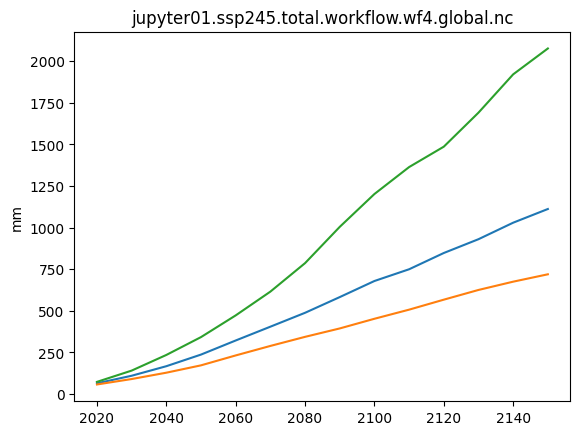

In [10]:
# plot quantiles of the time series

plt.plot(ds.years,ds.sea_level_change.quantile(.5,dim='samples'))
plt.plot(ds.years,ds.sea_level_change.quantile(.17,dim='samples'))
plt.plot(ds.years,ds.sea_level_change.quantile(.83,dim='samples'))

plt.ylabel('mm')
plt.title(datafile)

In [11]:
# display quantiles as a table

dq=ds.sea_level_change.quantile([.17,.5,.83],dim='samples')
u=dq[:,:,0]
print(u.to_pandas())

years          2020        2030        2040        2050        2060  \
quantile                                                              
0.17      56.805743   89.508850  127.624312  171.844491  231.410681   
0.50      63.904232  109.287922  166.684937  236.572937  321.277145   
0.83      72.447311  140.209671  234.306887  341.694685  472.171736   

years           2070        2080         2090         2100         2110  \
quantile                                                                  
0.17      288.583238  343.192608   393.761647   451.912081   506.716803   
0.50      404.294525  487.827133   582.223846   678.963654   749.578766   
0.83      615.168937  786.417618  1004.500820  1202.024659  1364.057809   

years            2120         2130         2140         2150  
quantile                                                      
0.17       566.748924   625.162411   674.943116   719.271763  
0.50       847.379547   930.301147  1029.573120  1111.867310  
0.83      1486.6